D(St)reams of Anomalies

In this project, I'll Inspect the habits of people in New York as they take taxis for transportation in the city. I will be analyzing how the number of taxi riders has changed from day to day as well as identifying anomalies in the data I am are analyzing.


Retrieving the Data

This data comes from the Numenta Anomaly Benchmark (NAB) dataset of NYC Taxi Rates on Kaggle, exactly under  but the raw data actually comes from the NYC Taxi and Limousine Commission website. I will begin by loading the dataset into a dataframe:

In [10]:
cd Prroject6/

/Users/danaalmansour/Desktop/Prroject6


In [11]:
ls

nyc_taxi.csv*


In [12]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.cm as cm
from pandas.plotting import register_matplotlib_converters
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from datetime import date

In [19]:
NNYCtaxi_df = pd.read_csv('nyc_taxi.csv')# Loading nyc_taxi.csv file

Running some info about the dataset

In [20]:
NYCtaxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [21]:
NYCtaxi_df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [22]:
NYCtaxi_df.shape

(10320, 2)

In [23]:
NYCtaxi_df.keys()

Index(['timestamp', 'value'], dtype='object')

Converting the timestamp column into an actual date object:

In [24]:
NYCtaxi_df["timestamp"] = pd.to_datetime(NYCtaxi_df["timestamp"])
NYCtaxi_df["timestamp"].describe()

count                   10320
unique                  10320
top       2014-11-12 04:30:00
freq                        1
first     2014-07-01 00:00:00
last      2015-01-31 23:30:00
Name: timestamp, dtype: object

In [25]:
NYCtaxi_df = NYCtaxi_df.rename(columns={"value": "num_passengers"})
NYCtaxi_df.keys()

Index(['timestamp', 'num_passengers'], dtype='object')

Checking for missing values

In [26]:
NYCtaxi_df[NYCtaxi_df.isna().any(axis=1)].shape[0]

0

There are no null values 

# Feature Engineering

Since I are trying to spot anomalies, the thing that might help the analysis is measuring how far away a point is from the mean value, while ignoring outliers. This will help our model to define what is standard and what is not

In [27]:
num_passengers = NYCtaxi_df["num_passengers"].values
# Let's get rid of the outliers
num_passengers_length = len(num_passengers)
num_passengers = num_passengers[(num_passengers_length // 8):num_passengers_length-(num_passengers_length // 8)]

# Calculate average and standard deviation
num_passengers_avg = int(np.floor(num_passengers.mean()))
print("Average number of passengers in a 30-minute period: {}".format(num_passengers_avg))
num_passengers_std = num_passengers.std()
print("Standard deviation of passengers in a 30-minute period: {}".format(num_passengers_std))

NYCtaxi_df["score_from_avg"] = np.power(((NYCtaxi_df["num_passengers"] - num_passengers_avg) / num_passengers_avg), 2)
NYCtaxi_df["score_from_avg"].describe()

Average number of passengers in a 30-minute period: 15245
Standard deviation of passengers in a 30-minute period: 6882.639838932542


count    1.032000e+04
mean     2.072349e-01
std      2.315752e-01
min      1.721096e-08
25%      2.078269e-02
50%      9.464351e-02
75%      3.550581e-01
max      2.468475e+00
Name: score_from_avg, dtype: float64

# Analysis

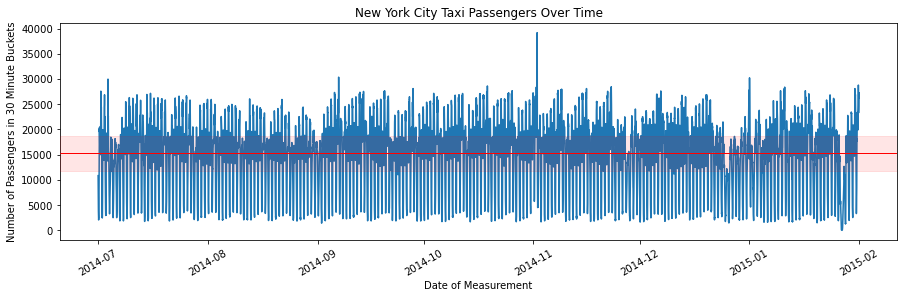

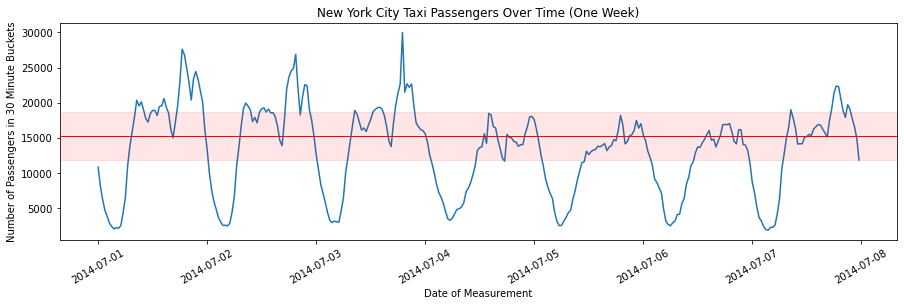

In [28]:
register_matplotlib_converters()

def show_NYCtaxi_data(data, title):
    plt.figure(figsize=(15, 4))

    plt.plot(data[:,0], data[:,1])
    plt.axhspan(num_passengers_avg - (num_passengers_std / 2), num_passengers_avg + (num_passengers_std / 2),
                color="red", alpha=0.1, zorder=5)
    plt.axhspan(num_passengers_avg - 1, num_passengers_avg + 1, color="red", zorder=6)
    plt.title(title)
    plt.xlabel("Date of Measurement")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Passengers in 30 Minute Buckets")

data = NYCtaxi_df.apply(lambda row: np.array(list((row["timestamp"], row["num_passengers"], row["score_from_avg"]))), axis=1)
data = np.array(list(data))
show_NYCtaxi_data(data, "New York City Taxi Passengers Over Time")

days_to_show = 7
day_data = data[:days_to_show * 48,:]
show_NYCtaxi_data(day_data, "New York City Taxi Passengers Over Time (One Week)")

plt.show()


It looks like I have some repeated data, and I can see some anomalies in the first graph. Some anomaly detection must be done in order to find the anomalies

# Detecting Anomalies

According to the Kaggle description of the nyc_taxi.csv dataset:

Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm

So I'M looking for 5 anomaly days:

2014-11-02 (NYC Marathon)
2014-11-27 (Thanksgiving)
2014-12-25 (Christmas)
2015-01-01 (New Years Day)
According to this https://en.wikipedia.org/wiki/January_2015_North_American_blizzard article, the snow storm referenced on the Kaggle description probably happened around 2015-01-26 to 2015-01-27



In [39]:
defined_anomalies = [("NYC Marathon", pd.to_datetime(["2014-11-02 00:00", "2014-11-02 23:59"])),
                     ("Thanksgiving", pd.to_datetime(["2014-11-27 00:00", "2014-11-27 23:59"])),
                     ("Christmas", pd.to_datetime(["2014-12-25 00:00", "2014-12-25 23:59"])),
                     ("New Years Day", pd.to_datetime(["2015-01-01 00:00", "2015-01-01 23:59"])),
                     ("Snow Storm", pd.to_datetime(["2015-01-26 00:00", "2015-01-27 23:59"]))]

outliers_fraction = 0.002 # This will be changed depending on the results

# If I use the current data, the model will yell at us for using a timestamp object
converted_data = np.array(data)
converted_data[:,0] = range(len(data))


# Isolation Forest


In [40]:
if_model = IsolationForest(contamination=outliers_fraction, behaviour="new")
if_pred = if_model.fit_predict(converted_data)

NYCtaxi_df_w_anomalies = NYCtaxi_df.merge(pd.Series(if_pred, name="anomaly"), left_index=True, right_index=True)
NYCtaxi_df_w_anomalies.head()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


,timestamp,num_passengers,score_from_avg,anomaly
0,2014-07-01 00:00:00,10844,0.083339,1
1,2014-07-01 00:30:00,8127,0.218002,1
2,2014-07-01 01:00:00,6210,0.351238,1
3,2014-07-01 01:30:00,4656,0.482453,1
4,2014-07-01 02:00:00,3820,0.561639,1


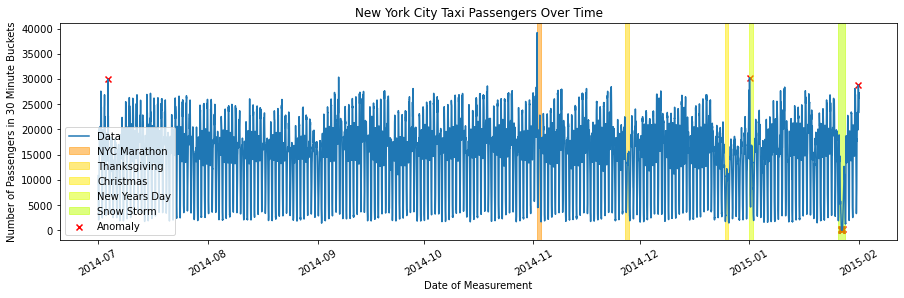

In [42]:
# Let's make this a function so I can use it later
def show_anomaly_data(anomalies):
    plt.figure(figsize=(15, 4))

    plt.plot(data[:,0], data[:,1], label="Data")
    plt.title("New York City Taxi Passengers Over Time")
    plt.xlabel("Date of Measurement")
    plt.xticks(rotation=30)
    plt.ylabel("Number of Passengers in 30 Minute Buckets")

    anomaly_data = anomalies.apply(lambda row: np.array(list((row["timestamp"], row["num_passengers"]))), axis=1)
    anomaly_data = np.array(list(anomaly_data))

    plt.scatter(anomaly_data[:,0], anomaly_data[:,1], c="red", marker="x", label="Anomaly")

    colors = cm.prism(np.linspace(0.4, 0.8, len(defined_anomalies)))
    for i, (date_name, (start_time, end_time)) in enumerate(defined_anomalies):
        plt.axvspan(start_time, end_time, color=colors[i], alpha=0.5, label=date_name)

    plt.legend(loc='lower left')
    plt.show()

c                                                                                                                                                         b   

Looking good! Values I have as anomalies:


In [43]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 3), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 26), datetime.date(2015, 1, 27),
       datetime.date(2015, 1, 31)], dtype=object)

Anomaly Date	Significance
2015-01-10	       None
2015-01-26   	Snow Storm

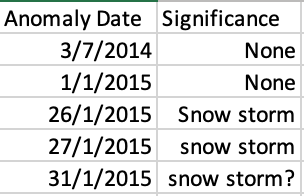

I got 3 of the 5 anomalous dates mentioned, including 2 new dates that weren't mentioned in the dataset description. However, according to Kaggle's description, I're still missing NYC Marathon (11/2/2014), Christmas (12/25/2014), and Thanksgiving (11/27/2014), so some tweaking must be done in order to get more dates


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


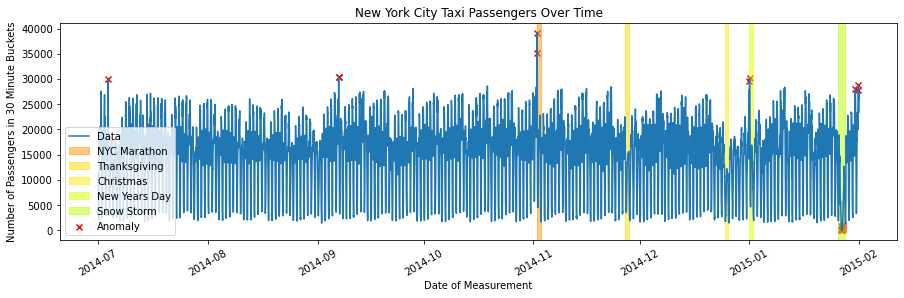

In [48]:
outliers_fraction = 0.003
if_model = IsolationForest(contamination=outliers_fraction, behaviour="new")
if_pred = if_model.fit_predict(converted_data)

NYCtaxi_df_w_anomalies = NYCtaxi_df.merge(pd.Series(if_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = NYCtaxi_df_w_anomalies.loc[NYCtaxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)


In [49]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 3), datetime.date(2014, 9, 6),
       datetime.date(2014, 11, 2), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 26), datetime.date(2015, 1, 27),
       datetime.date(2015, 1, 30), datetime.date(2015, 1, 31)],
      dtype=object)

I got more dates! Checking for the values:

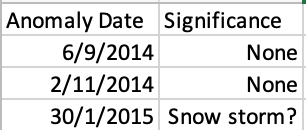

Not what I wished for but I will use another model for better accuracy. 

Local Outlier Factor


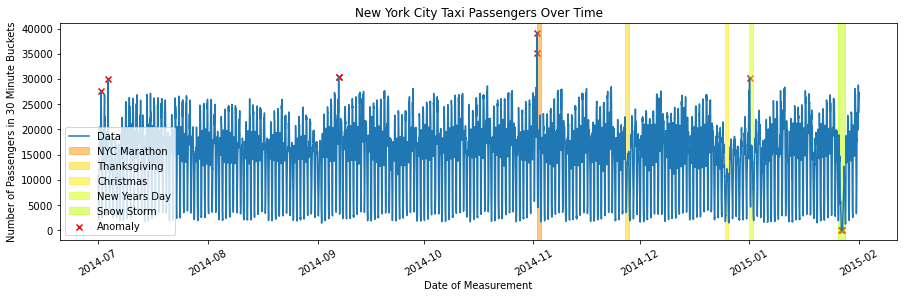

In [30]:
outliers_fraction = 0.002
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=outliers_fraction)
lof_pred = lof_model.fit_predict(converted_data)

NYCtaxi_df_w_anomalies = NYCtaxi_df.merge(pd.Series(lof_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = NYCtaxi_df_w_anomalies.loc[NYCtaxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [31]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 1), datetime.date(2014, 7, 3),
       datetime.date(2014, 9, 6), datetime.date(2014, 11, 2),
       datetime.date(2015, 1, 1), datetime.date(2015, 1, 27)],
      dtype=object)

Using the Local Outlier Factor appears to give us the same result as the Isolation Forest, but with an additional unspecified anomaly date. However, we can see that one point of the snow storm that is closer to kaggle description  is available

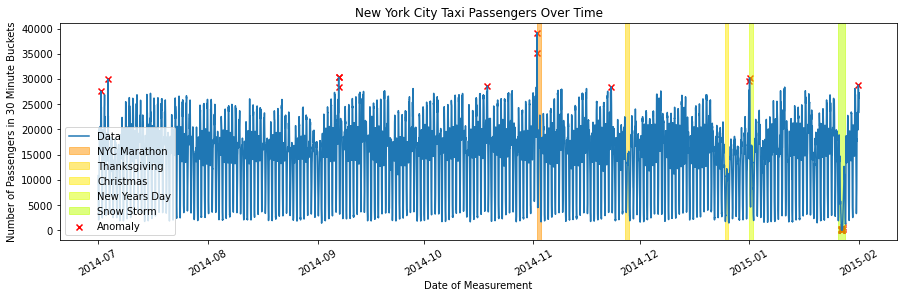

In [33]:
outliers_fraction = 0.003
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=outliers_fraction)
lof_pred = lof_model.fit_predict(converted_data)

NYCtaxi_df_w_anomalies = NYCtaxi_df.merge(pd.Series(lof_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = NYCtaxi_df_w_anomalies.loc[NYCtaxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [34]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 1), datetime.date(2014, 7, 3),
       datetime.date(2014, 9, 6), datetime.date(2014, 10, 18),
       datetime.date(2014, 11, 2), datetime.date(2014, 11, 22),
       datetime.date(2015, 1, 1), datetime.date(2015, 1, 26),
       datetime.date(2015, 1, 27), datetime.date(2015, 1, 31)],
      dtype=object)

Increasing the outliers fraction works in a similar way to Isolation Forest, where I get more unspecified dates but not new specific dates




Why can't I find Thanksgiving or Christmas?

I think that might be due to the fact that in those days there were fewer taxi riders during the day when there were usually more taxi riders. This incidence did not create an extreme point (a data point outside the typical range of points), but it did cause a change in the cyclic pattern. I will try to make the model aware of the cycles to be able to identify these anomalies.

To do this, I'll split the date into day and time columns:

In [36]:
NYCtaxi_df["date"] = [d.date() for d in NYCtaxi_df['timestamp']]
NYCtaxi_df["time"] = [d.time() for d in NYCtaxi_df['timestamp']]
NYCtaxi_df.head()

,timestamp,num_passengers,score_from_avg,date,time
0,2014-07-01 00:00:00,10844,0.083339,2014-07-01,00:00:00
1,2014-07-01 00:30:00,8127,0.218002,2014-07-01,00:30:00
2,2014-07-01 01:00:00,6210,0.351238,2014-07-01,01:00:00
3,2014-07-01 01:30:00,4656,0.482453,2014-07-01,01:30:00
4,2014-07-01 02:00:00,3820,0.561639,2014-07-01,02:00:00


Now I can convert these and plug them into the models:



In [37]:
converted_data = []
date_groups = NYCtaxi_df.groupby("date")
for i, (name, group) in enumerate(date_groups):
    arr = list(zip(range(48), group["num_passengers"].values))
    converted_data.extend(np.array(list(map(lambda x: (i, x[0], x[1]), arr))))
converted_data[:5]

[array([    0,     0, 10844]),
 array([   0,    1, 8127]),
 array([   0,    2, 6210]),
 array([   0,    3, 4656]),
 array([   0,    4, 3820])]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_iforest.py:252: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


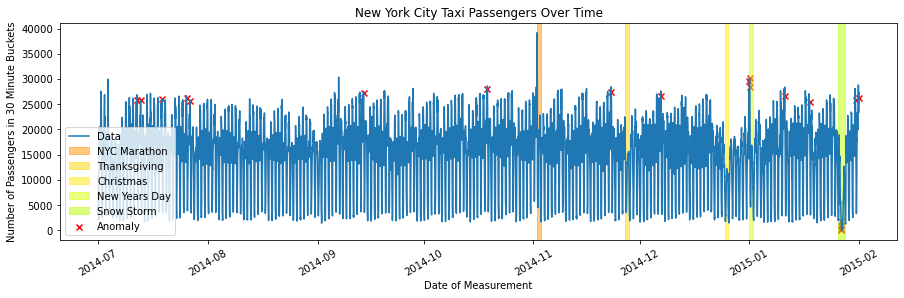

In [38]:
outliers_fraction = 0.002
if_model = IsolationForest(contamination=outliers_fraction, behaviour="new")
if_pred = if_model.fit_predict(converted_data)

NYCtaxi_df_w_anomalies = NYCtaxi_df.merge(pd.Series(if_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = NYCtaxi_df_w_anomalies.loc[NYCtaxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [39]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 12), datetime.date(2014, 7, 13),
       datetime.date(2014, 7, 19), datetime.date(2014, 7, 26),
       datetime.date(2014, 7, 27), datetime.date(2014, 9, 14),
       datetime.date(2014, 10, 19), datetime.date(2014, 11, 23),
       datetime.date(2014, 12, 7), datetime.date(2015, 1, 1),
       datetime.date(2015, 1, 11), datetime.date(2015, 1, 18),
       datetime.date(2015, 1, 26), datetime.date(2015, 1, 27),
       datetime.date(2015, 1, 31)], dtype=object)

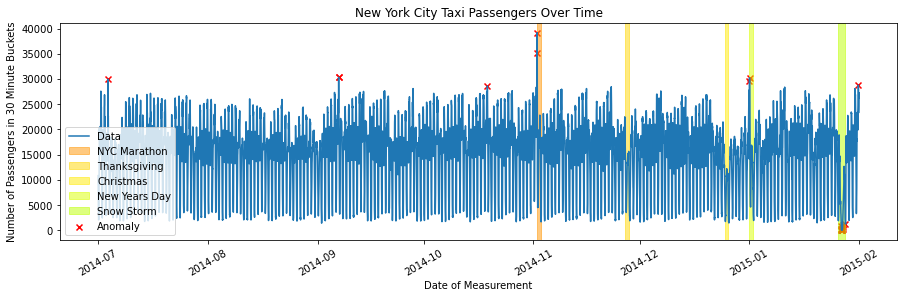

In [40]:
outliers_fraction = 0.003
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=outliers_fraction)
lof_pred = lof_model.fit_predict(converted_data)

NYCtaxi_df_w_anomalies = NYCtaxi_df.merge(pd.Series(lof_pred, name="anomaly"), left_index=True, right_index=True)
anomalies = NYCtaxi_df_w_anomalies.loc[NYCtaxi_df_w_anomalies["anomaly"] != 1]
show_anomaly_data(anomalies)

In [41]:
anomalies["timestamp"].apply(lambda t: date(t.year, t.month, t.day)).unique()

array([datetime.date(2014, 7, 3), datetime.date(2014, 9, 6),
       datetime.date(2014, 10, 18), datetime.date(2014, 11, 2),
       datetime.date(2015, 1, 1), datetime.date(2015, 1, 26),
       datetime.date(2015, 1, 27), datetime.date(2015, 1, 28),
       datetime.date(2015, 1, 31)], dtype=object)

Unfortunately, This model still did not detect the cycles, even when I split the date up to help me show that there were cycles.

Conclusion

Finally, the best anomaly detection model (isolation forest with a fraction of 0.002) was shown to identify 3/5 of the identified anomaly dates, with only two unspecified dates. This result is pleasing, as a look at the graph shows that the model did a great job of finding outliers, whether it was due to more taxi riders or fewer taxi riders.

Also, even though I increased the fraction of outliers to be 0.003, the isolation forest model predicted new points of anomalies that were not specified in the Kaggle description. Nevertheless, I tried to use the local external factor but ended up with a similar result.

Why can't I find Thanksgiving or Christmas?

I think that might be due to the fact that in those days there were fewer taxi riders during the day when there were usually more taxi riders. This incidence did not create an extreme point (a data point outside the typical range of points), but it did cause a change in the cyclic pattern. Our models appear to be good at finding these outliers that lie outside the average range of data points, but they aren't necessarily considerable at finding deviations in cyclic time-series data.
